In [45]:
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n = 1000
ages = np.random.normal(loc=35, scale=10, size=n).astype(int)
incomes = np.random.exponential(scale=20000, size=n).astype(int) + 30000
genders = np.random.choice(['Male', 'Female'], size=n)
membership_duration = np.random.gamma(shape=2, scale=3, size=n).astype(int)
shopping_freq = np.random.choice(['Weekly', 'Monthly', 'Rarely'], size=n)
last_purchase_amount = np.random.normal(loc=100, scale=20, size=n) * np.random.choice([1, 2, 3, 4, 5], size=n)

# Define plausible relationships for category assignments
def assign_category(row):
    if row['Income'] > 70000 and row['Last_Purchase_Amount'] > 150:
        return np.random.choice(['Electronics', 'Home & Garden'], p=[0.6, 0.4])
    elif row['Age'] < 30 and row['Shopping_Frequency'] == 'Weekly':
        return np.random.choice(['Clothing', 'Beauty'], p=[0.7, 0.3])
    else:
        return 'Sports & Outdoors'

# Assign product categories based on the defined relationships
df = pd.DataFrame({
    'Age': ages,
    'Income': incomes,
    'Gender': genders,
    'Membership_Duration': membership_duration,
    'Shopping_Frequency': shopping_freq,
    'Last_Purchase_Amount': last_purchase_amount
})

df['Product_Category'] = df.apply(assign_category, axis=1)

# Introduce unbalance in the target classes
df['Product_Category'] = df['Product_Category'].replace({
    'Electronics': np.random.choice(['Electronics', 'Sports & Outdoors'], p=[0.1, 0.9]),
    'Clothing': 'Clothing',
    'Beauty': 'Beauty',
    'Home & Garden': 'Home & Garden',
    'Sports & Outdoors': 'Sports & Outdoors'
})

# Introduce missing values
missingness = ['Age', 'Income', 'Last_Purchase_Amount']
for col in missingness:
    df.loc[df.sample(frac=0.1).index, col] = np.nan

print(df.head())

df.to_csv("data/purchase_data.csv",index=False)

    Age   Income  Gender  Membership_Duration Shopping_Frequency  \
0  39.0  33666.0  Female                    5            Monthly   
1  33.0  32208.0  Female                    2             Weekly   
2  41.0  50235.0    Male                    6            Monthly   
3  50.0  54515.0  Female                    5            Monthly   
4  32.0  30641.0  Female                   15            Monthly   

   Last_Purchase_Amount   Product_Category  
0            491.190876  Sports & Outdoors  
1            450.973526  Sports & Outdoors  
2            292.943468  Sports & Outdoors  
3            606.233366  Sports & Outdoors  
4            295.601691  Sports & Outdoors  


## Introduction

For this week, we will use some generated data to practice your ML skills.  The data simulates customer purchase behavior across different product categories.  Your job is to predict the target classes with a classifier.

__Target Classes:__ 5 product categories (Electronics, Clothing, Home & Garden, Beauty, Sports & Outdoors).

__Features:__

- Age: Numeric, representing the age of the customer.
- Income: Numeric, representing the yearly income of the customer.
- Gender: Categorical, male or female.
- Membership_Duration: Numeric, years of being a member of the online store.
- Shopping_Frequency: Categorical, frequency of shopping (Weekly, Monthly, Rarely).
- Last_Purchase_Amount: Numeric, amount spent in the last purchase.

#### __Exercise 1__

Inspect the data - does it have any nulls?  Outliers?  Use a scatter matrix to visualize the numeric data, and examine histograms for the categorical data.

In [31]:
df = pd.read_csv("data/purchase_data.csv")
df
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1000 non-null   int64  
 1   Age                   900 non-null    float64
 2   Income                900 non-null    float64
 3   Gender                1000 non-null   object 
 4   Membership_Duration   1000 non-null   int64  
 5   Shopping_Frequency    1000 non-null   object 
 6   Last_Purchase_Amount  900 non-null    float64
 7   Product_Category      1000 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 62.6+ KB


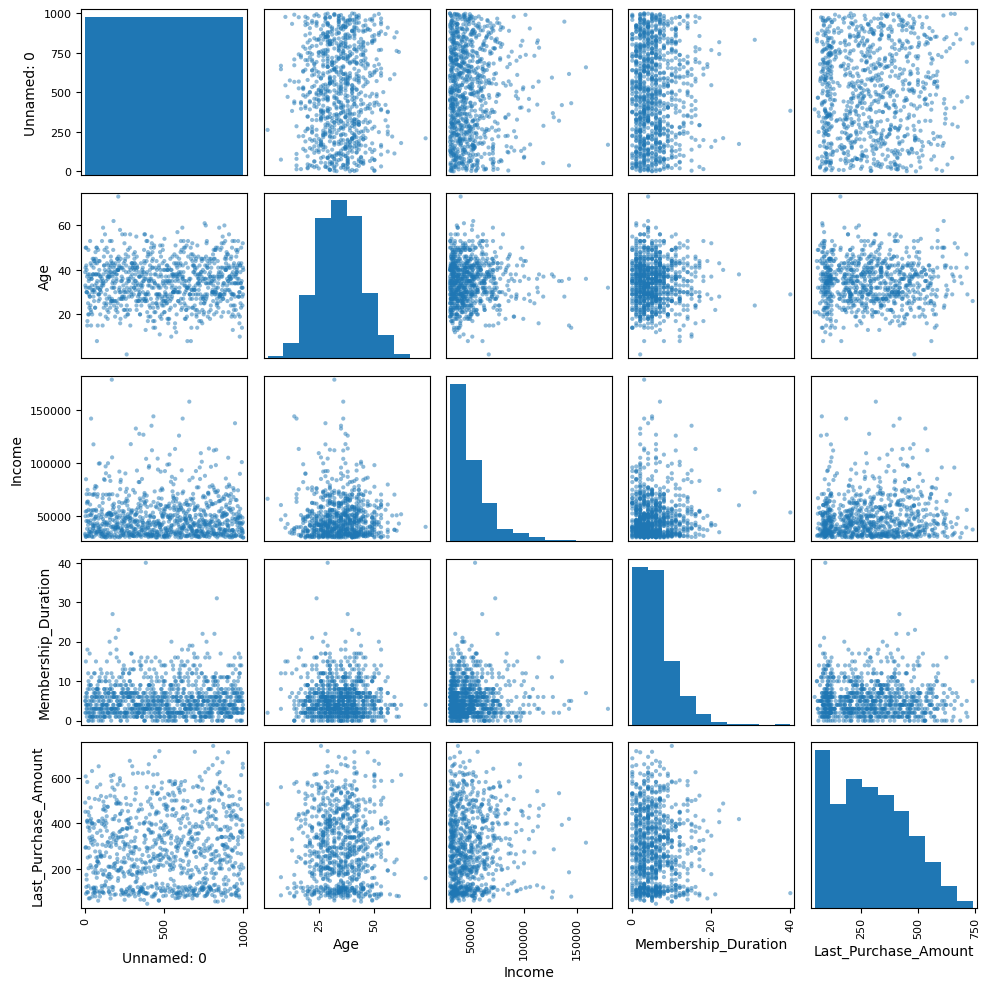

In [32]:
import matplotlib.pyplot as plt
pd.plotting.scatter_matrix(df,figsize=(10,10))
plt.tight_layout()
plt.show()

<Axes: xlabel='Product_Category'>

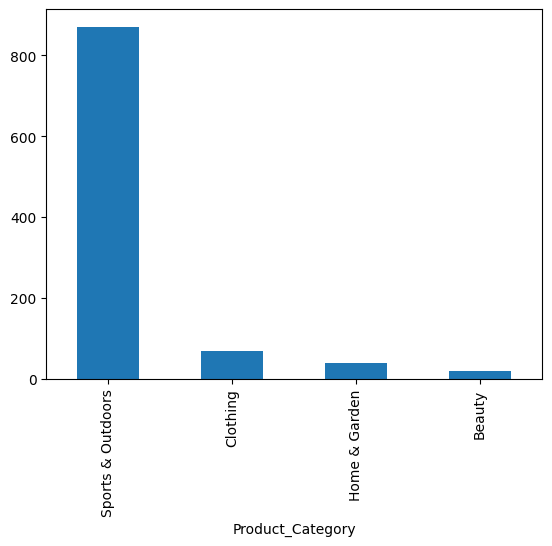

In [33]:
df.Product_Category.value_counts().plot.bar()

#### __Exercise 2__

Impute your missing data! Use whatever methods you want.

In [34]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
df = pd.read_csv("data/purchase_data.csv")

# Imputing numeric columns using median
numeric_cols = ['Age', 'Income', 'Membership_Duration', 'Last_Purchase_Amount']
for col in numeric_cols:
    median_imputer = SimpleImputer(strategy='median')
    df[col] = median_imputer.fit_transform(df[[col]])

# Imputing categorical columns using mode
categorical_cols = ['Gender', 'Shopping_Frequency', 'Product_Category']
for col in categorical_cols:
    print(col)
    mode_imputer = SimpleImputer(strategy='most_frequent')
    df[[col]] = mode_imputer.fit_transform(df[[col]].astype(str))

df.info()

Gender
Shopping_Frequency
Product_Category
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1000 non-null   int64  
 1   Age                   1000 non-null   float64
 2   Income                1000 non-null   float64
 3   Gender                1000 non-null   object 
 4   Membership_Duration   1000 non-null   float64
 5   Shopping_Frequency    1000 non-null   object 
 6   Last_Purchase_Amount  1000 non-null   float64
 7   Product_Category      1000 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 62.6+ KB


#### __Exercise 3__

Encode your data properly (one-hot encode for features, label encode for targets) and scale your numeric features using a standard scaler.


In [46]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer

# Assuming 'df' is already read and imputed as mentioned

# Define categorical and numeric features
categorical_features = ['Gender', 'Shopping_Frequency']
numeric_features = ['Age', 'Income', 'Membership_Duration', 'Last_Purchase_Amount']

# Create a column transformer with OneHotEncoder for categorical data and StandardScaler for numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(SimpleImputer(strategy="median"),StandardScaler()), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fit and transform the preprocessor on the data
df_transformed = preprocessor.fit_transform(df)

# Convert the output back to a DataFrame (optional, if you want to see the transformed data)
column_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
df_transformed = pd.DataFrame(df_transformed, columns=column_names)

# Label encode the target variable
label_encoder = LabelEncoder()
df_transformed['Product_Category'] = label_encoder.fit_transform(df['Product_Category'])

# Output the transformed DataFrame
df_transformed

,Age,Income,Membership_Duration,Last_Purchase_Amount,Gender_Female,Gender_Male,Shopping_Frequency_Monthly,Shopping_Frequency_Rarely,Shopping_Frequency_Weekly,Product_Category
0,0.472676,-0.830606,-0.154965,1.330103,1.0,0.0,1.0,0.0,0.0,3
1,-0.171882,-0.907338,-0.828724,1.061397,1.0,0.0,0.0,0.0,1.0,3
2,0.687528,0.041389,0.069622,0.005542,0.0,1.0,1.0,0.0,0.0,3
3,1.654365,0.266637,-0.154965,2.098743,1.0,0.0,1.0,0.0,0.0,3
4,-0.279308,-0.989806,2.090900,0.023302,1.0,0.0,1.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...
995,-0.279308,-0.676774,-0.828724,0.666035,0.0,1.0,0.0,0.0,1.0,3
996,1.869218,-0.779452,-0.154965,2.468978,0.0,1.0,0.0,0.0,1.0,3
997,0.687528,-0.258486,-0.379551,2.355099,1.0,0.0,1.0,0.0,0.0,3
998,-0.601587,-1.017752,-0.604138,-0.085724,0.0,1.0,1.0,0.0,0.0,3


#### __Exercise 4__

Note that your classes are imbalanced.  Use SMOTE to rebalance them.

In [36]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
smote = SMOTE(random_state=42)
X = df_transformed.drop("Product_Category",axis=1)
y = df_transformed.Product_Category
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
y_resampled_smote.value_counts()

Product_Category
3    871
1    871
0    871
2    871
Name: count, dtype: int64

#### __Exercise 5__

Try modeling with a LogisticRegression.  Use cross validation to evaluate your accuracy and F1-scores for each class, as well as your average performance across all classes.

In [37]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import f1_score, accuracy_score

# Assuming X and y are already prepared, and 'le' is the LabelEncoder for y

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=10000)

# Get cross-validated predictions
y_pred = cross_val_predict(lr_model, X_resampled_smote, y_resampled_smote, cv=5)

# Calculate accuracy using cross_val_score
accuracy = cross_val_score(lr_model, X_resampled_smote, y_resampled_smote, cv=5, scoring='accuracy')

# Calculate F1 score for each class
f1_macro = f1_score(y_resampled_smote, y_pred, average='macro')
f1_weighted = f1_score(y_resampled_smote, y_pred, average='weighted')
f1_class = f1_score(y_resampled_smote, y_pred, average=None)

# Output the results
print(f"Cross-Validation Accuracy Scores: {accuracy}")
print(f"Average Accuracy: {np.mean(accuracy):.3f}")

print(f"F1 Macro Score: {f1_macro:.3f}")
print(f"F1 Weighted Score: {f1_weighted:.3f}")

# Print F1 score for each class
print("F1 Scores for each class:")
class_labels = label_encoder.classes_  # Retrieve original class labels from LabelEncoder
for label, score in zip(class_labels, f1_class):
    print(f"  Class {label}: F1 Score = {score:.3f}")

Cross-Validation Accuracy Scores: [0.69870875 0.71879484 0.72022956 0.71449067 0.7183908 ]
Average Accuracy: 0.714
F1 Macro Score: 0.714
F1 Weighted Score: 0.714
F1 Scores for each class:
  Class Beauty: F1 Score = 0.571
  Class Clothing: F1 Score = 0.544
  Class Home & Garden: F1 Score = 0.892
  Class Sports & Outdoors: F1 Score = 0.850


#### __Exercise 6__

If you've not done so already, place all of your operations in a pipeline.  Now try running your model with a DecisionTreeClassifier.  Which performs better?

In [53]:
# Note that we need to use the pipeline from IMBLearn for this to work
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate

df = pd.read_csv("data/purchase_data.csv")

categorical_features = ['Gender', 'Shopping_Frequency']
numeric_features = ['Age', 'Income', 'Membership_Duration', 'Last_Purchase_Amount']
target_features = ['Product_Category']

# Create a column transformer with OneHotEncoder for categorical data and StandardScaler for numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(SimpleImputer(strategy="median"),StandardScaler()), numeric_features),
        ('cat', make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder()), categorical_features),
    ])

pipeline = make_pipeline(preprocessor ,SMOTE(), LogisticRegression())
X = df.drop(target_features,axis=1)
le = LabelEncoder()
y = le.fit_transform(df[target_features[0]])


#pipeline.fit(X,y)
# We're using "macro" here so we can evaluate both of our classes - this is unusual for binary targets
cross_validate(pipeline,X,y,scoring=['f1_macro'])


{'fit_time': array([0.04678583, 0.04433012, 0.04034209, 0.04265904, 0.03967524]),
 'score_time': array([0.00904894, 0.00549793, 0.00551295, 0.00692797, 0.0051899 ]),
 'test_f1_macro': array([0.43083709, 0.47330985, 0.45354287, 0.50276395, 0.4415138 ])}

In [54]:
from sklearn.tree import DecisionTreeClassifier
pipeline = make_pipeline(preprocessor ,SMOTE(), DecisionTreeClassifier())
cross_validate(pipeline,X,y,scoring=['f1_macro'])

{'fit_time': array([0.02905703, 0.0312252 , 0.02416301, 0.02420878, 0.02357078]),
 'score_time': array([0.00718904, 0.00542998, 0.00532794, 0.00543213, 0.0048151 ]),
 'test_f1_macro': array([0.49252642, 0.63440623, 0.54611345, 0.60966839, 0.68726763])}